In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF



In [6]:
data = pd.read_csv("C:\REPOS\Kaggle\CongressionalVotingID.shuf.lrn.csv",na_values=['unknown'])
data.drop('ID',axis=1,inplace=True) #DROP ID
data.replace(('y', 'n'), (1, 0), inplace=True) #Replace Y = 1 ; N = 0
#data.head() #Y = 1; N = 0; unknown = NaN

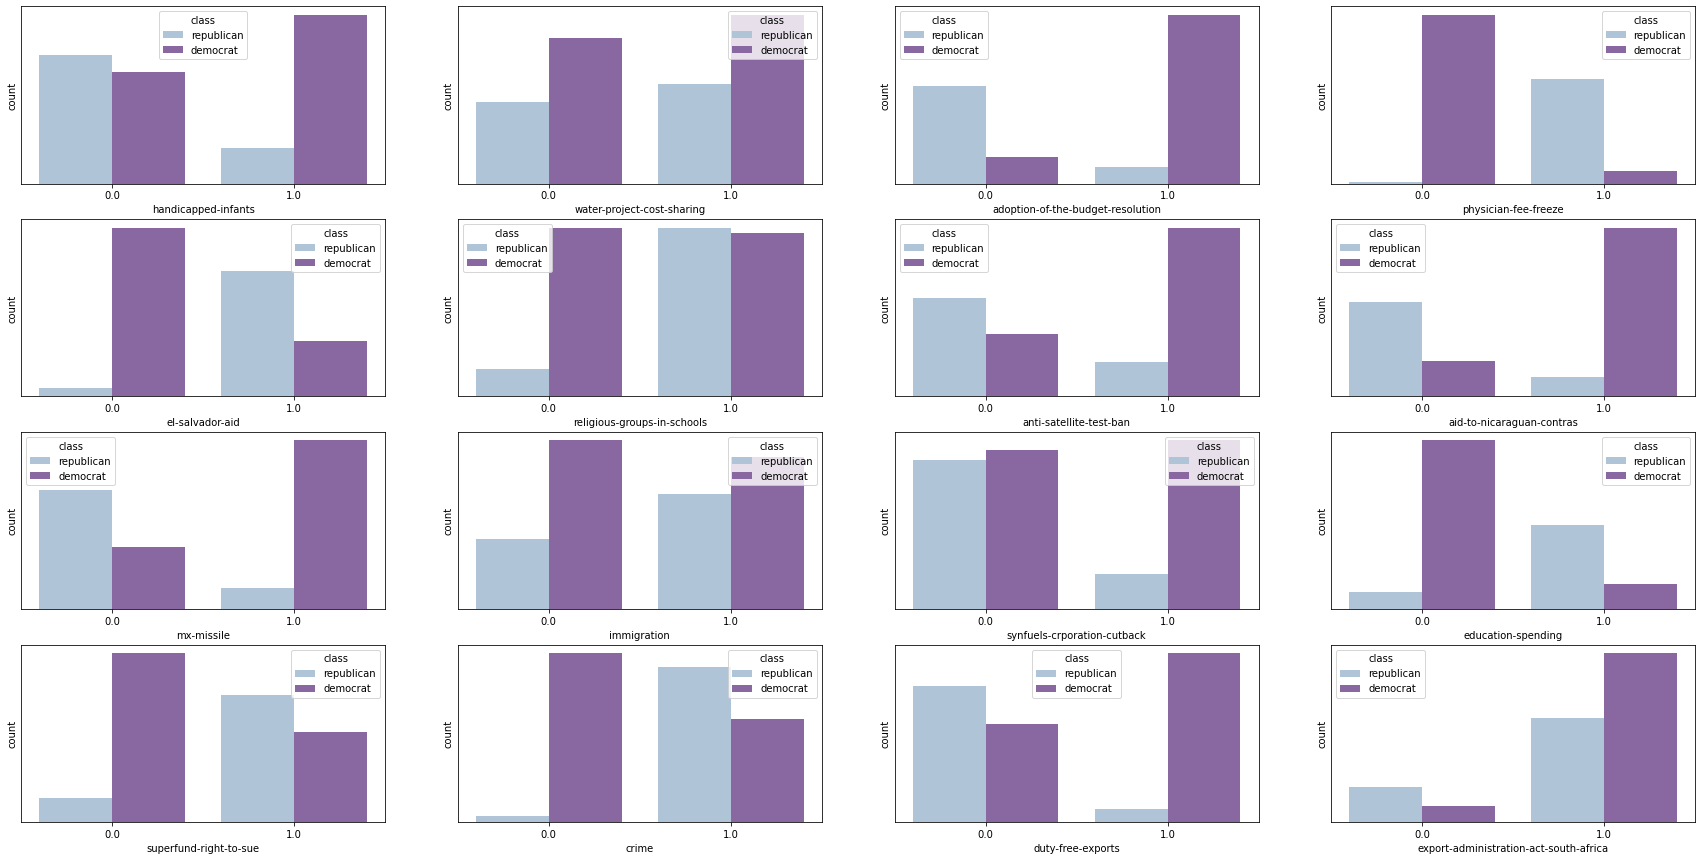

In [35]:
graphs = data.drop('class', axis=1).columns 
z = 0
fig, axes = plt.subplots(4, 4, figsize=(30, 15))
for i in range(4):
     #graphs = np.where(y_train == i)[0] # seleciona as imagens de cada tipo para ser plotada no grafico.
     for j in range(4):     
         sns.countplot(x = graphs[z+j], hue='class', data=data, palette='BuPu', ax=axes[i][j])
         axes[i][j].set_yticks([])
     z = z + j + 1
plt.show()

In [7]:
df = data.replace(('democrat', 'republican'), (0, 1), inplace=False)

In [ ]:
#Creates Report
#CongressionalVotes = pandas_profiling.ProfileReport(df)
#CongressionalVotes.to_file('CongressionalVotes.html')
#CongressionalVotes

In [37]:
#Crete X and Y
df_imp = df
imp = SimpleImputer(strategy="most_frequent")


y = df_imp['class'].values
X = df_imp.drop('class', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

#IMPUTE MODELS
X_train = imp.fit_transform(X_train)

# XG BOOOOOST ME

In [14]:
from xgboost import XGBClassifier

In [36]:
def hyperParameterTuning(X_train, y_train, X_test):
    param_tuning = {
        'learning_rate': [0.01],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500,1000],
        'objective': ['binary:logistic'],
        'eval_metric' : ['error','logloss']
    }

    xgb_model = XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'accuracy', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           verbose = 2)

    gsearch.fit(X_train,y_train)
    best_random = gsearch.best_estimator_
    y_pred = best_random.predict(X_test)
    acc_vote = accuracy_score(y_test, y_pred)
    print("Acc: ",acc_vote)
    return gsearch.best_params_

In [32]:
hyperParameterTuning(X_train, y_train, X_test)
#best param -> {'colsample_bytree': 0.7, 'eval_metric': 'error', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'binary:logistic', 'subsample': 0.7}

=binary:logistic, subsample=0.5 
[CV]  colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective=binary:logistic, subsample=0.5, total=   0.4s
[CV] colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective=binary:logistic, subsample=0.7 
[CV]  colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective=binary:logistic, subsample=0.7, total=   0.4s
[CV] colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective=binary:logistic, subsample=0.7 
[CV]  colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective=binary:logistic, subsample=0.7, total=   0.4s
[CV] colsample_bytree=0.7, eval_metric=logloss, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimator

{'colsample_bytree': 0.7,
 'eval_metric': 'error',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'binary:logistic',
 'subsample': 0.7}

In [ ]:
def evaluate_model(X, y, model):
    K = 5
    R = 3

    cv = RepeatedStratifiedKFold(n_splits=K, n_repeats=R, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)
    return scores

def get_models():
    models, names = list(), list()
    
    models.append(GaussianProcessClassifier(kernel = (1.0 * RBF(1.0))))
    names.append('GPC')

    # SVM
    models.append(LogisticRegression())
    names.append('LG')

    models.append(DecisionTreeClassifier())
    names.append('DT')

    models.append(GaussianNB())
    names.append('GNB')   

    #models.append(MultinomialNB())
    #names.append('MNB')   

    models.append(SVC())
    names.append('SVC')

    models.append(NuSVC())
    names.append('NuSVC')

    models.append(SGDClassifier())
    names.append('SGD')
      
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    
    models.append(ExtraTreesClassifier(n_estimators=1000))
    names.append('ET')
    
    return models, names

def evaluate(model, test_features, test_labels):
    probs_votos = model.predict_proba(test_features)
    accuracy = roc_auc_score(test_labels, probs_votos[:,1])
    return accuracy

In [ ]:


#Create Acc Graphs
models, names = get_models()
results = list()
print("Model", "Mean", "Std")

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
#TEST DATA X
df_test_id = pd.read_csv("C:\REPOS\Kaggle\CongressionalVotingID.shuf.tes.csv",na_values=['unknown'])
df_test = df_test_id.drop('ID',axis=1) #DROP ID
df_test.replace(('y', 'n'), (1, 0), inplace=True) #Replace Y = 1 ; N = 0

test_X = df_test.values
test_X = imp.fit_transform(test_X)


In [ ]:
clf = SVC(probability=True,kernel="rbf",gamma='scale',decision_function_shape='ovo',C=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(test_X)

submit = pd.DataFrame()

df_id = df_test_id['ID'].astype(int)
df_result = pd.DataFrame(y_pred).astype(int)
df_result.replace((0, 1), ('democrat', 'republican'), inplace=True)
df_result.columns = ['class']

submit['ID'] = df_id
submit['class'] = df_result

#df_id.to_csv('ID_final.csv',index= False)
#df_result.to_csv('Result_final.csv',index= False)

submit.to_csv('submit.csv',index= False)

#acc_vote = accuracy_score(y_test, y_pred)
#print("Acc: ",acc_vote)


In [ ]:
#Export to Kaggle

clf = RandomForestClassifier(random_state=42,n_estimators = 400,min_samples_split=5,min_samples_leaf=1,max_features = "sqrt",max_depth = 30, bootstrap = True)


#Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
clf.fit(X_train,y_train)

predicts = clf.predict(test_X)

#acc_vote = accuracy_score(test, predicts)
#print("Acc: ",acc_vote)

df_predicts = pd.DataFrame(predicts)
#df_predicts.drop('0',axis=1)
df_id = pd.DataFrame(df_test_id['ID'])

df_predicts.replace((0,1), ("democrat", "republican"), inplace=True)
#result = pd.concat([df_results,df_predicts],axis=1)

#df_results['predicts'] = df_predicts

#df_result = pd.DataFrame(result)
#df_result.insert(1,"ID",df_test_id['ID'])

#df_results['Result'] = df_result
#df_results.insert(2,"Result",df_result)

#df_test_ids = pd.read_csv("C:\REPOS\Kaggle\CongressionalVotingID.shuf.tes.csv",na_values=['unknown'])
#df_results.insert(0,"ID",df_test_ids['ID'])
df_predicts.to_csv("Preds.csv",index=False)
df_id.to_csv("Ids.csv",index=False)

    

In [ ]:
#RANDOM FOREST ------------------------------------------------------------------------------------------------

rf = RandomForestClassifier(random_state=0,n_estimators = 1400,min_samples_split=5,min_samples_leaf=1,max_features = "log2",max_depth = 30, bootstrap = True)
#Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
#Params: {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
# KNN ------------------------------------------------------------------------------------------------

knn = KNeighborsClassifier(n_neighbors=4,weights='uniform',leaf_size=10,algorithm='auto')
#Params: {'weights': 'uniform', 'n_neighbors': 4, 'leaf_size': 10, 'algorithm': 'auto'}

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
# ET ------------------------------------------------------------------------------------------------

#models.append(ExtraTreesClassifier(n_estimators=1000))
et = ExtraTreesClassifier(n_estimators=1000)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
# DECISION TREE ------------------------------------------------------------------------------------------------------------------

dt = DecisionTreeClassifier(random_state=0,splitter="random",max_features='log2',criterion='entropy')
#Params: {'splitter': 'random', 'max_features': 'log2', 'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0}

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)


In [ ]:
# NAVIE BAYES ------------------------------------------------------------------------------------------------

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
# SVC ------------------------------------------------------------------------------------------------
svc = SVC(probability=True,kernel="rbf",gamma='scale',decision_function_shape='ovo',C=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
dt = DecisionTreeClassifier(random_state=0,splitter="random",max_features='log2',criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(test_X)
df_predicts = pd.DataFrame(y_pred)
df_predicts.replace((0,1), ("democrat", "republican"), inplace=True)
df_predicts.to_csv("Preds_dt.csv",index=False)




# GRID SEARCHES

In [ ]:
#grid search - extra trees

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
criterion = ['gini','entropy']
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
oob_score = [True,False]
class_weight = ['balanced','balanced_subsample']

# grid
et_grid = {'n_estimators': n_estimators,
            'criterion' : criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score':oob_score,
               'class_weight' : class_weight
               }

In [ ]:
et = ExtraTreesClassifier(random_state = 42)
# cross valuation using 3 folds
et_random = RandomizedSearchCV(estimator=et, param_distributions=et_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=1, random_state=42, n_jobs=1,
                             pre_dispatch= 2,return_train_score=True)

# Fit
et_random.fit(X_train, y_train)
print('Params:',et_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = et_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
#grid search - random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced','balanced_sample']

# grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight' : class_weight
               }

print(random_grid)

In [ ]:
rf = RandomForestClassifier(random_state = 42)
# cross valuation using 3 folds
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=1,
                             pre_dispatch= 2,
                              return_train_score=True)

# Fit
rf_random.fit(X_train, y_train)
print('Params:',rf_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = rf_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
print("AUC:" ,evaluate(best_random, X_test, y_test))

In [ ]:
#grid search - KNN
n_neighbors = [2,3,4,5,6]
weights = ['uniform','distance']
algorithm = ['auto','ball_tree']
leaf_size = [1, 10, 30, 50, 100]

# grid
kn_grid = {'n_neighbors' : n_neighbors,
                'weights': weights,
               'algorithm': algorithm,
               'leaf_size': leaf_size
               }

print(kn_grid)

In [ ]:
kn = KNeighborsClassifier()
# cross valuation using 3 folds
kn_random = RandomizedSearchCV(estimator=kn, param_distributions=kn_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=1,
                              return_train_score=True)

# Fit
kn_random.fit(X_train, y_train)
print('Params:',kn_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = kn_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)


In [ ]:
#grid search - DT
criterion = ['gini','entropy']
splitter = ['best','random']
max_depth = ['None',2,4,6]
#min_samples_split =
#min_samples_leaf
#max_leaf_nodes
max_features = ['auto','sqrt','log2']
ccp_alpha = [0,2,4,6]

# grid
dt_grid = {'criterion' : criterion,
           'splitter': splitter,
           'max_depth': max_depth,
           'max_features': max_features,
           'ccp_alpha': ccp_alpha
               }

print(dt_grid)

In [ ]:
dt = DecisionTreeClassifier()
# cross valuation using 3 folds
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=dt_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=1,
                              return_train_score=True)

# Fit
dt_random.fit(X_train, y_train)
print('Params:',dt_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = dt_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)


In [ ]:
#grid search - svc
C = [2,5,7,10,20,40,80,160]
kernel = ['rbf','linear']
#degree = [1,3,6,12,24,28]
gamma = ['scale','auto',0.1,0.01,0.001]
probability = [True,False]
coef0 = [1,3,6,12,24,28]
class_weight = [None,'balanced']
decision_function_shape = ['ovo','ovr']




# grid
svc_grid = {'C' : C,
            'kernel' : kernel,
            #'degree' : degree,
            'gamma' : gamma,
            'probability': probability,
            'coef0' : coef0,
            'class_weight' : class_weight,
            'decision_function_shape' : decision_function_shape
               }

In [ ]:
svc = SVC()
# cross valuation using 3 folds
svc_random = GridSearchCV(estimator=svc, param_grid=svc_grid, scoring='accuracy', 
                              cv = 3, verbose=2,n_jobs=-1,
                              return_train_score=True)

# Fit
svc_random.fit(X_train, y_train)
print('Params:',svc_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = svc_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)


In [ ]:
df_na = df.dropna()
y = df_na['class'].values
X = df_na.drop('class', axis=1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [ ]:
df_imp = df
y = df_imp['class'].values
X = df_imp.drop('class', axis=1).values


imp = SimpleImputer(strategy="most_frequent")
X = imp.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [ ]:
# SVC
svc = SVC(probability=True,kernel="rbf",gamma='scale',decision_function_shape='ovo',C=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)

In [ ]:
# Voting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
from sklearn.ensemble import VotingClassifier

svc2 = SVC(probability=True,kernel="rbf",gamma='scale',decision_function_shape='ovo',C=3)
rf2 = RandomForestClassifier(random_state=0,n_estimators = 1400,min_samples_split=5,min_samples_leaf=1,max_features = "log2",max_depth = 30, bootstrap = True)
et2 = ExtraTreesClassifier(oob_score = False, n_estimators= 1200, min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 40, criterion= 'entropy', class_weight= 'balanced_subsample', bootstrap= True)

eclf = VotingClassifier(
    estimators=[('svc2',svc2),('rf2',rf2),('et2',et2)],
    voting='soft')

params = {'svc2__C': [1.0, 100.0], 'rf2__n_estimators': [20, 200], 'svc2__gamma' : ['scale','auto',0.1,0.01,0.001]}

#grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5,verbose=1)
#grid.fit(X_train, y_train)
#print(grid.cv_results_)
#res = grid.cv_results_
# for clf, label in zip([svc, rf, et ,eclf], ['SVC', 'Random Forest','Extra Tree', 'Ensemble']):
#     scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


for clf, label in zip([svc2, rf2, et2 ,eclf], ['SVC', 'Random Forest','Extra Tree', 'Ensemble']):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc_vote = accuracy_score(y_test, y_pred)
    print("Acc: ",acc_vote)


In [ ]:
#clf = SVC(probability=True,kernel="rbf",gamma='scale',decision_function_shape='ovo',C=3)

y_pred = eclf.predict(test_X)

submit = pd.DataFrame()

df_id = df_test_id['ID'].astype(int)
df_result = pd.DataFrame(y_pred).astype(int)
df_result.replace((0, 1), ('democrat', 'republican'), inplace=True)
df_result.columns = ['Class']

submit['ID'] = df_id
submit['class'] = df_result

#df_id.to_csv('ID_final.csv',index= False)
#df_result.to_csv('Result_final.csv',index= False)

submit.to_csv('submit.csv',index= False)

#acc_vote = accuracy_score(y_test, y_pred)
#print("Acc: ",acc_vote)



In [ ]:
d123 = pd.read_csv("C:\REPOS\KAGGLE\ID_final.csv",delimiter = ";")
d123.to_csv("Results_final2.csv",index=False)

In [ ]:
# MLP

mlp = MLPClassifier(solver='sgd',activation='tanh',learning_rate='constant', alpha=1e-5,hidden_layer_sizes=(10, 4), random_state=1,max_iter=2400)
#activation': 'tanh', 'hidden_layer_sizes': (10, 4), 'learning_rate': 'constant', 'max_iter': 1200, 'solver': 'sgd'

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)


In [ ]:
#grid search - mlp
hidden_layer_sizes = [(10,4),10,(20,8,20),(40,16,40),(80,32,80),(160,64,160),(420,128,420)]
activation = ['logistic','tanh','relu']
solver = [,'sgd','adam']
learning_rate = ['constant','adaptive']
max_iter = [1200,2400]

# grid
mlp_grid = {'hidden_layer_sizes' : hidden_layer_sizes,
            'activation' : activation,
            'solver' : solver,
            'learning_rate': learning_rate,
            'max_iter':max_iter
               }

In [ ]:
mlp = MLPClassifier()
# cross valuation using 3 folds
mlp_random = GridSearchCV(estimator=mlp, param_grid=mlp_grid, scoring='accuracy', 
                              cv = 3, verbose=1,n_jobs=1,
                              return_train_score=True)

# Fit
mlp_random.fit(X_train, y_train)
print('Params:',mlp_random.best_params_)
# selection of the best model and evaluation of the accuracy of the model
best_random = mlp_random.best_estimator_
# making the prediction in the test files
y_pred = best_random.predict(X_test)
# model accuracy assessment
acc_vote = accuracy_score(y_test, y_pred)
print("Acc: ",acc_vote)
